 Raul Jimenez Ayza, NIU: 1688916
 
 Marc Estape Ayen, NIU: 1630270

GitHub : https://github.com/NIU1688916/Kaggle_LOL

# cas Kaggle: League of Legends Ranked Games


Installs neccessaris per funcionament de practica:

In [10]:
#es para instalar el kaggle-->con ! o %
# %pip install kaggle 
# %pip install seaborn

Imports:

In [1]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (train_test_split, StratifiedKFold,  GridSearchCV, cross_val_score)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_squared_error, mean_absolute_error, make_scorer, r2_score, precision_recall_curve, roc_curve, auc


Archius del cas:

In [2]:
api = KaggleApi()
#api.config  = os.path.join(os.getcwd(),'kaggle.json')
api.authenticate()

dataser_owner = 'datasnaek'
dataset_name= 'league-of-legends'
dataset = f'{dataser_owner}/{dataset_name}'

if not os.path.isdir('data_kaggle'):
  os.mkdir('data_kaggle')
  api.dataset_download_files(dataset = dataset,path = 'data_kaggle')
  zf = ZipFile(f'data_kaggle/{dataset_name}.zip')
  zf.extractall(f'data_kaggle/{dataset_name}') #save files in selected folder
  zf.close()

df = pd.read_csv(f'data_kaggle/{dataset_name}/games.csv')

print(df.head(10))

       gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0  3326086514  1504279457970          1949         9       1           2   
1  3229566029  1497848803862          1851         9       1           1   
2  3327363504  1504360103310          1493         9       1           2   
3  3326856598  1504348503996          1758         9       1           1   
4  3330080762  1504554410899          2094         9       1           2   
5  3287435705  1501667992132          2059         9       1           2   
6  3314215542  1503430065724          1993         9       1           1   
7  3329224025  1504472363684          1334         9       1           1   
8  3318040883  1503686577549          1387         9       2           2   
9  3327786881  1504385918871          2681         9       2           2   

   firstTower  firstInhibitor  firstBaron  firstDragon  ...  t2_towerKills  \
0           1               1           1            1  ...              5   
1      

In [3]:
numero = df.shape[1]
noms = df.columns.tolist()
print("Número d'atributs:", numero)
print("Atributs:", noms)
df.info()

Número d'atributs: 61
Atributs: ['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']

In [4]:
#Treiem les que visualment sabem que no ens donen cap tipus d'informacio:
df=df.drop(columns=['creationTime','seasonId','gameId'])

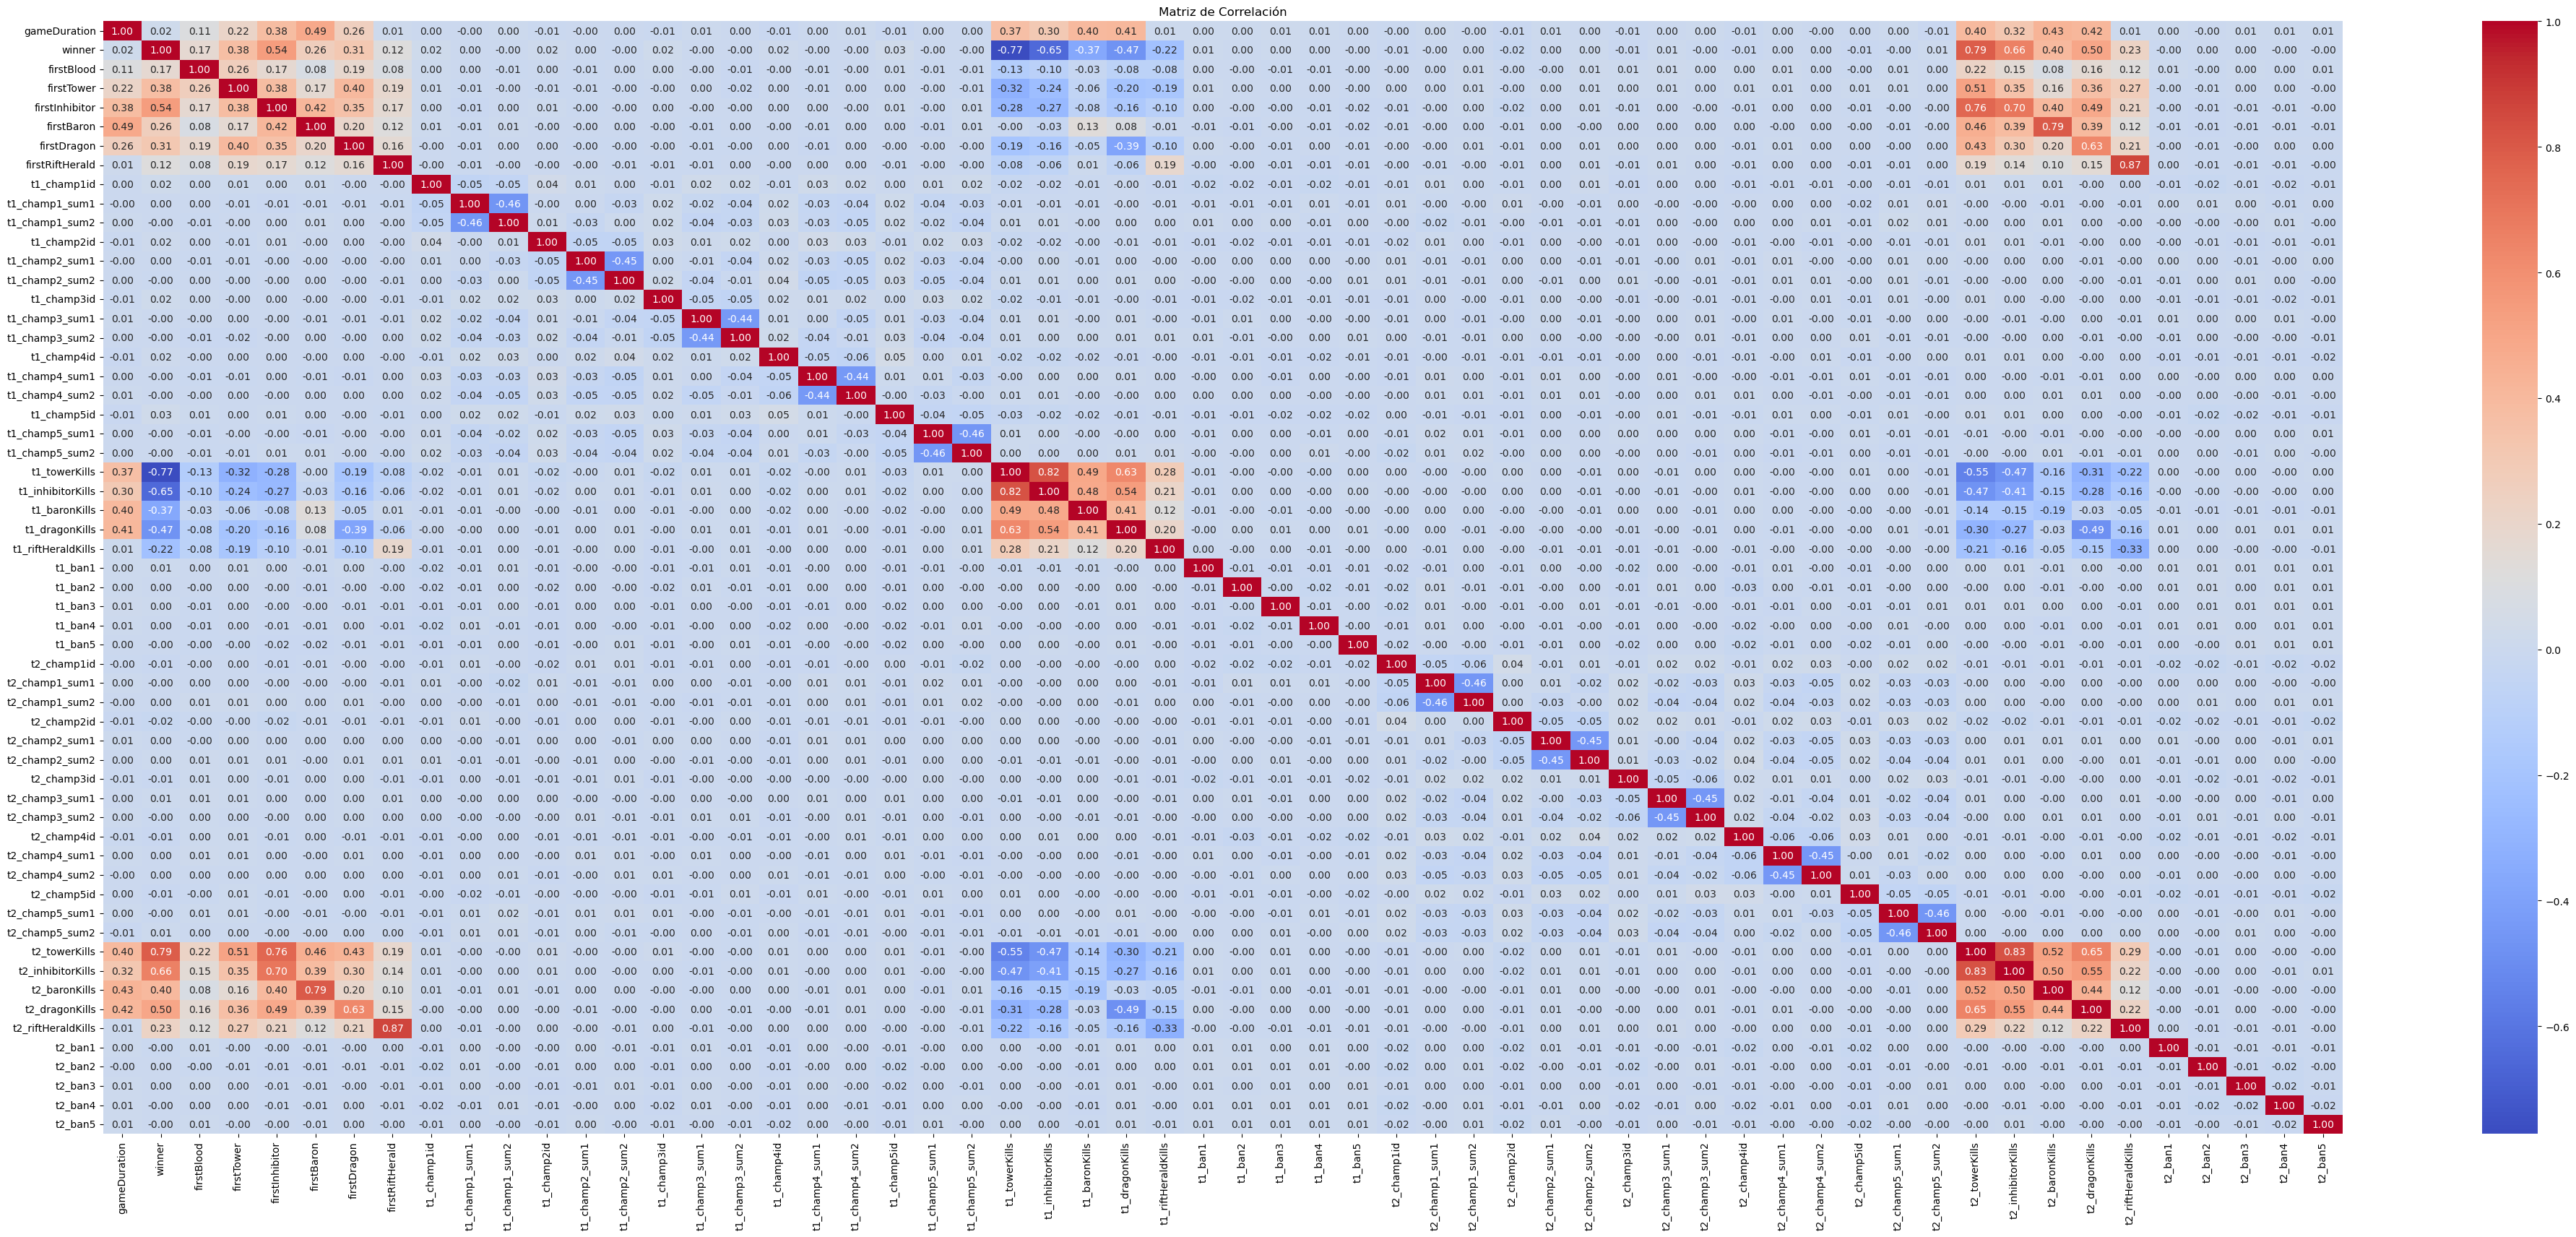

In [5]:
#Anem a veure la informacio que ens donen la resta de variables
correlation_matrix = df.corr()
plt.figure(figsize=(50, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [6]:
#Agafem nomes les variables que ens aporten.
df=df[['winner','firstBlood','firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald','t1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills','t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills',]]

print("\nNulls:")
df.isnull().sum()



Nulls:


winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
t1_riftHeraldKills    0
t2_towerKills         0
t2_inhibitorKills     0
t2_baronKills         0
t2_dragonKills        0
t2_riftHeraldKills    0
dtype: int64

In [7]:
print(df.dtypes['winner'])
print(df['winner'].unique())

int64
[1 2]


In [8]:
# Tamaño de los datos de entrenamiento
print("Tamaño de los datos de entrenamiento:", df.shape)

Tamaño de los datos de entrenamiento: (51490, 17)


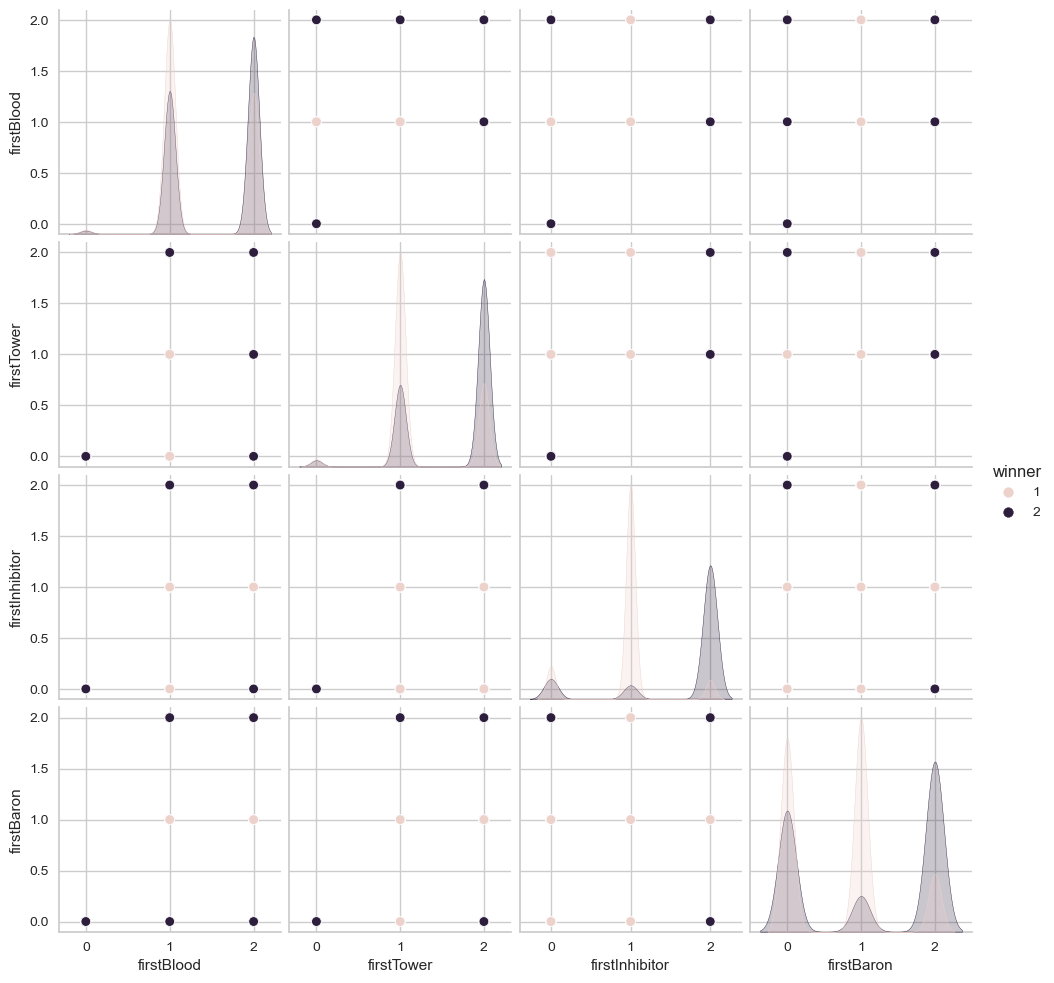

In [101]:
dfPlot = df.iloc[:,:5]
sns.pairplot(dfPlot, hue='winner')

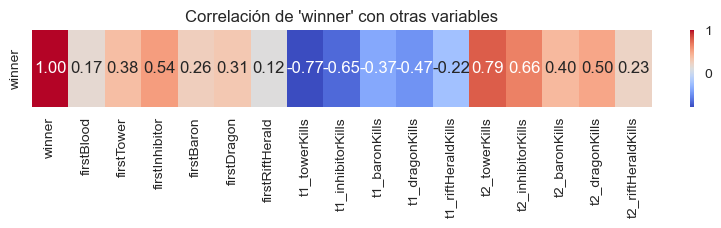

In [102]:
# Seleccionar la fila correspondiente a "winner" en la matriz de correlación
correlation_matrix = df.corr()
winner_correlation = correlation_matrix.loc[['winner']]

# Visualización de la fila de "winner" en un mapa de calor
plt.figure(figsize=(10, 1))  # Ajustar el tamaño para mostrar solo una fila
sns.heatmap(winner_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlación de 'winner' con otras variables")
plt.show()

# Metricas y seleccion de modelo


Valores con GradientBoostingClassifier:

In [13]:
# Definir las columnas y la variable objetivo
columnas = ['firstBlood','firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald','t1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills','t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills']
target = 'winner'

X = df[columnas]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)

# Crear y entrenar el modelo GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=26)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9733928918236551

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.97      2563
           2       0.98      0.97      0.97      2586

    accuracy                           0.97      5149
   macro avg       0.97      0.97      0.97      5149
weighted avg       0.97      0.97      0.97      5149


Confusion Matrix:
[[2503   60]
 [  77 2509]]


Valores con RandomForest:

In [110]:
X = df[columnas]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)

# Crear y entrenar el modelo RandomForestClassifier
model_rf = RandomForestClassifier(random_state=26)
model_rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.9702854923286075

Classification Report (Random Forest):
              precision    recall  f1-score   support

           1       0.97      0.97      0.97      2563
           2       0.97      0.97      0.97      2586

    accuracy                           0.97      5149
   macro avg       0.97      0.97      0.97      5149
weighted avg       0.97      0.97      0.97      5149


Confusion Matrix (Random Forest):
[[2493   70]
 [  83 2503]]


Valores con AdaBoostClassifier:

In [14]:
X = df[columnas]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)

# Crear y entrenar el modelo AdaBoostClassifier
model_ada = AdaBoostClassifier(random_state=26)
model_ada.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_ada = model_ada.predict(X_test)

# Evaluar el modelo
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'Ada Boosting Accuracy: {accuracy_ada}')

print("\nClassification Report (Ada Boosting):")
print(classification_report(y_test, y_pred_ada))

print("\nConfusion Matrix (Ada Boosting):")
print(confusion_matrix(y_test, y_pred_ada))

c:\Users\Nitropc\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ada Boosting Accuracy: 0.9683433676442028

Classification Report (Ada Boosting):
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      2563
           2       0.98      0.96      0.97      2586

    accuracy                           0.97      5149
   macro avg       0.97      0.97      0.97      5149
weighted avg       0.97      0.97      0.97      5149


Confusion Matrix (Ada Boosting):
[[2505   58]
 [ 105 2481]]


# Entrenament

In [9]:
#Agafem X com característiques i Y com a variable objectiu.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Definim els models seleccionats i les seves caracterisitques a provar
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier()
}
params = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 150, 200, 300],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'class_weight': [None, 'balanced','desbalanced'],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [1, 3, 5, 7, 8],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0], 
        'max_features': ['sqrt', 'log2'] 
    }
}

resultat_GS = []
best_params_GS = {}

for model_name, model in models.items():

    print(f"Buscando hiperparámetros óptimos para {model_name}...")

    # Trobar els millors hiperparàmetres amb Grid Search
    grid_search = GridSearchCV(model, params[model_name], cv=kfold, scoring='accuracy', n_jobs=-1)  
    grid_search.fit(x_train, y_train) 
    estimator = grid_search.best_estimator_

    best_params_GS[model_name] = grid_search.best_params_

    #Evaluar els models amb aquests paràmetres
    y_pred_test_GS = estimator.predict(x_test)
    accuracy_result_GS = accuracy_score(y_test, y_pred_test_GS)

    # Guardem els resultats del model
    resultat_GS.append([model_name, grid_search.best_score_, accuracy_result_GS])

# Mostrem els resultats obtinguts
print("\nPuntuacions Grid Search: ")

resultat_GS_df = pd.DataFrame(resultat_GS, columns=['Model', 'Accuracy Score Train ', 'Accuracy Score Test'])
print(resultat_GS_df)
print("\nMillors paràmetres GS: ")
print(best_params_GS)

#¡¡CUIDADO 68min de ejeccucion!!

NameError: name 'X' is not defined

# Analisis Final


Creem una funció que ens permeti mostrar les curves ROC i PR :

In [10]:
def plot_performance_curve(model, X_test, y_test, curve_type="pr"):

    # Normalitzem els valors ja que no es entre 1-0 sino 2-1
    y_test_binary = np.where(y_test == 2, 1, 0)  # Assumeix que 2 = guanyar i 1 = perdre
     
    # Generem les probabilitats de predicció
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Inicialitzem valors per a guardar les mètriques
    metrics = {}

    if curve_type == "pr":
        # Calculem la corba Precision-Recall
        precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_prob)
        
        # Calculem l'AUC de la corba Precision-Recall
        auc_value = auc(recall, precision)
        metrics["AUC"] = (auc_value, None, None)
        
        # Trobar el punt òptim (màxim F1-score)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]
        metrics["Punt Òptim (F1)"] = (optimal_threshold, optimal_precision, optimal_recall)
        
        # Trobar la precisió màxima
        max_precision_idx = np.argmax(precision)
        max_precision = precision[max_precision_idx]
        max_precision_recall = recall[max_precision_idx]
        metrics["Màxima Precisió"] = (thresholds[max_precision_idx - 1] if max_precision_idx > 0 else 0, max_precision, max_precision_recall)
        
        # Trobar el recall màxim
        max_recall_idx = np.argmax(recall)
        max_recall = recall[max_recall_idx]
        max_recall_precision = precision[max_recall_idx]
        metrics["Màxim Recall"] = (thresholds[max_recall_idx - 1] if max_recall_idx > 0 else 0, max_recall_precision, max_recall)
        
        # Gràfic de la corba Precision-Recall amb punts d'interès
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, color='darkorange', lw=2, label=f'PRC (AUC = {auc_value:.2f})')
        no_skill = len(y_test[y_test == 1]) / len(y_test)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='grey', label='Sense habilitat')
        plt.scatter(optimal_recall, optimal_precision, c='green', marker='o', s=100, label=f'Punt òptim (F1 = {f1_scores[optimal_idx]:.2f})')
        plt.scatter(max_precision_recall, max_precision, c='blue', marker='o', s=100, label='Màxima Precisió')
        plt.scatter(max_recall, max_recall_precision, c='red', marker='o', s=100, label='Màxim Recall')
        plt.xlabel('Recall')
        plt.ylabel('Precisió')
        plt.title('Corba Precision-Recall')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    elif curve_type == "roc":
        # Calculem la corba ROC
        fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)
        
        # Calculem l'AUC de la corba ROC
        auc_value = auc(fpr, tpr)
        metrics["AUC"] = (auc_value, None, None)
        
        # Trobar el punt òptim (màxim F1-score)
        f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        metrics["Punt Òptim (F1)"] = (optimal_threshold, optimal_fpr, optimal_tpr)
        
        # FPR mínim (precisió màxima en la corba ROC)
        min_fpr_idx = np.argmin(fpr)
        min_fpr = fpr[min_fpr_idx]
        max_tpr_at_min_fpr = tpr[min_fpr_idx]
        metrics["Mínim FPR"] = (thresholds[min_fpr_idx], min_fpr, max_tpr_at_min_fpr)
        
        # TPR màxim
        max_tpr_idx = np.argmax(tpr)
        max_tpr = tpr[max_tpr_idx]
        min_fpr_at_max_tpr = fpr[max_tpr_idx]
        metrics["Màxim TPR"] = (thresholds[max_tpr_idx], min_fpr_at_max_tpr, max_tpr)
        
        # Gràfic de la corba ROC amb punts d'interès
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_value:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Sense habilitat')
        plt.scatter(optimal_fpr, optimal_tpr, c='green', marker='o', s=100, label=f'Punt òptim (F1 = {f1_scores[optimal_idx]:.2f})')
        plt.scatter(min_fpr, max_tpr_at_min_fpr, c='blue', marker='o', s=100, label='Mínim FPR')
        plt.scatter(min_fpr_at_max_tpr, max_tpr, c='red', marker='o', s=100, label='Màxim TPR')
        plt.xlabel('Taxa de Falsos Positius (FPR)')
        plt.ylabel('Taxa de Veritables Positius (TPR)')
        plt.title('Corba ROC')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    
    # Convertim el diccionari de mètriques a un DataFrame i el mostrem
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Llindar', 'Precisió/Recall/FPR', 'Recall/TPR'])
    print(metrics_df)

Un cop tenim el model amb la millor puntuació i quins son els seus paràmetres òptims anem a fer un report final


Accuracy-Score (Train): 0.97143
Accuracy-Score (Test): 0.97281


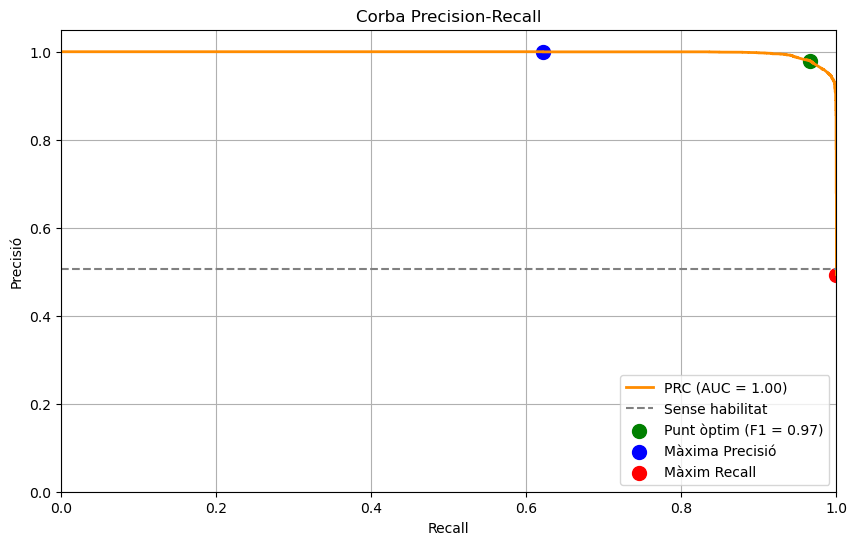

                  Llindar  Precisió/Recall/FPR  Recall/TPR
AUC              0.997727                  NaN         NaN
Punt Òptim (F1)  0.541098             0.979653    0.966162
Màxima Precisió  0.972786             1.000000    0.620893
Màxim Recall     0.000000             0.493591    1.000000


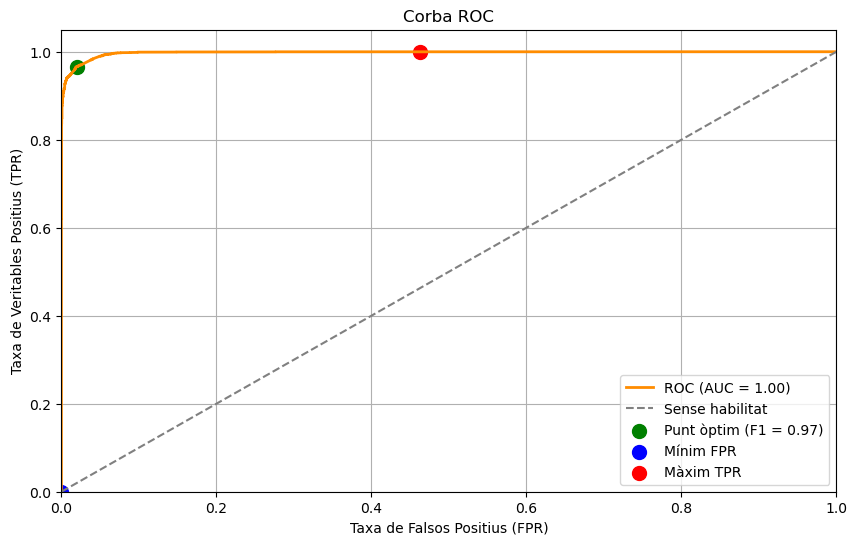

                  Llindar  Precisió/Recall/FPR  Recall/TPR
AUC              0.997730                  NaN         NaN
Punt Òptim (F1)  0.541098             0.019559    0.966162
Mínim FPR             inf             0.000000    0.000000
Màxim TPR        0.026027             0.463279    1.000000


In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=26)

gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features='sqrt', min_samples_split=5, n_estimators=300, subsample=0.8)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=26)

scores = cross_val_score(gb, X_train, y_train, cv=kfold, scoring='accuracy')

acc_train = scores.mean()

gb.fit(X_train, y_train)
y_pred_test = gb.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy-Score (Train): {acc_train:.5f}')
print(f'Accuracy-Score (Test): {acc_test:.5f}')

plot_performance_curve(gb, X_test, y_test, 'pr')
plot_performance_curve(gb, X_test, y_test, 'roc')